In [2]:
class LiftFinder():
    b = 0
    PI = 3.1415926536
    v_infinity = 0
    rho = 0
    c(x) = 0
    alphaL0(x) = 0
    alpha(x) = 0
    N = 0
    x_axis_reference = []
    lift_vector = []
    total_lift = 0
    lift_coeff = 0
    
    def __init__(self,wing_info):
        self.b = wing_info[0]
        self.v_infinity = wing_info[1]
        self.rho = wing_info[2]
        self.c = SR(wing_info[3].replace("pi", str(self.PI)))
        self.alphaL0 = SR(wing_info[4].replace("pi", str(self.PI)))
        self.alpha = SR(wing_info[5].replace("pi", str(self.PI)))
        self.N = int(wing_info[6])
        LiftFinder.get_lift(self)
        


    def five_fifty_one(self):
        x = var("x")
        N = self.N
        alpha = self.alpha
        alphaL0 = self.alphaL0
        pi = self.PI
        b = self.b
        c = self.c
        rhs_vector = [0 for i in range(N)]
        eqParts = [[0 for i in range(N)] for i in range(N)]
        #The last column is the RHS, alpha(theta) - alphaL0(theta)
        for row in range(0, N):
            theta = pi * (row + 1)/(N+1) # This gets N non-zero thetas evenly distributed, using pi * row / N would have zero as the first value
            rhs_vector[row] = [alpha(x=theta) - alphaL0(x=theta)] # assign last column
            
            for col in range(0, N):
                n = col + 1
                eqParts[row][col] = (2 * b * sin(n * theta)) / (pi * c(x=theta)) + (n * sin(n * theta)) / sin(theta)

        an_vector = matrix(eqParts).solve_right(matrix(rhs_vector))
        return an_vector


    def gamma(self):
        pi = self.PI
        N = self.N
        alpha = self.alpha
        b = self.b
        v_infinity = self.v_infinity
        
        an_vector = LiftFinder.five_fifty_one(self)
        gamma_per_theta = [0 for i in range(0, N)]
        for theta_lcv in range(0, N):
            sum = 0
            theta = pi * (theta_lcv + 1) / (N + 1)
            for i in range(0, N): #i is the loop control variable, n is what we're using in the actual sum
                n = i + 1
                sum = sum + an_vector[i][0] * sin(n * theta)
            gamma_per_theta[theta_lcv] = sum * 2 * b * v_infinity
        return gamma_per_theta


    def lift_finder(self):
        gamma_per_theta = LiftFinder.gamma(self)
        rho = self.rho
        v_infinity = self.v_infinity
        lift_vector = []
        for value in gamma_per_theta:
            lift_vector.append(rho * v_infinity * (value))
        self.lift_vector = LiftFinder.full_lift_vector(self, lift_vector)
        self.x_axis_reference = LiftFinder.generate_x_axis(self)


    def get_lift(self):
        #Calculates total lift using a middle reimann sum
        LiftFinder.lift_finder(self)
        N = self.N
        full_lift_vector = self.lift_vector
        x_axis_reference = self.x_axis_reference
        
        
        total = 0
        for index in range(N + 1):
            delta_x = abs(x_axis_reference[index] - x_axis_reference[index + 1])
            avg = (full_lift_vector[index] + full_lift_vector[index + 1]) / 2
            total = total + delta_x * avg
        self.total_lift = total
        LiftFinder.lift_coefficient(self)
        return total

    
    def get_zipped_lists(self):
       return list(zip(self.x_axis_reference, self.lift_vector))
   

    def get_x_axis_reference(self):
        return self.x_axis_reference
    def get_lift_vector(self):
        return self.lift_vector
    def get_total_lift(self):
        return self.total_lift
    
    # Some helper methods
    def generate_x_axis(self):
        pi = self.PI
        N = self.N
        b = self.b
        
        x_axis_reference = [- b / 2]
        for n in range(0, N):
            theta = pi * (n + 1)/(N+1)
            x_axis_reference.append(-b/2*(cos(theta)))

        x_axis_reference.append(b/2)
        return x_axis_reference
    

    def full_lift_vector(self, lift_vector):
    #Adds the initial and final 0 of the lift vector for graphing purposes
        lift_per_y = [0]

        for value in lift_vector:
            lift_per_y.append(value)
        lift_per_y.append(0)
        
        return lift_per_y
    
    def lift_coefficient(self):
        rho = self.rho
        v_infinity = self.v_infinity
        b = self.b
        c = self.c
        total_lift = self.total_lift
        
        dynamic_pressure = 1/2 * rho * v_infinity ^ 2
        s = b * average_value(c)
        self.lift_coeff = ((total_lift) / (dynamic_pressure * s))
        
    def get_lift_coefficient(self):
        return self.lift_coeff



def average_value(func):
    #Helper method for finding the lift coefficient
    x = var("x")
    vals = [i * pi / 101. for i in range(102)]
    func = SR(func)
    sum = 0
    for i in vals:
        sum = sum + func(x=i)
    return sum / len(vals)

Total lift for wing 0 = 20021.8284407485
Lift coefficient: 0.261509595960797
b: 10
v_infinity: 50
rho: 1.22500000000000
c(theta): 5
alphaL0(theta): 0
alpha(theta): 5 * pi/180
N: 10


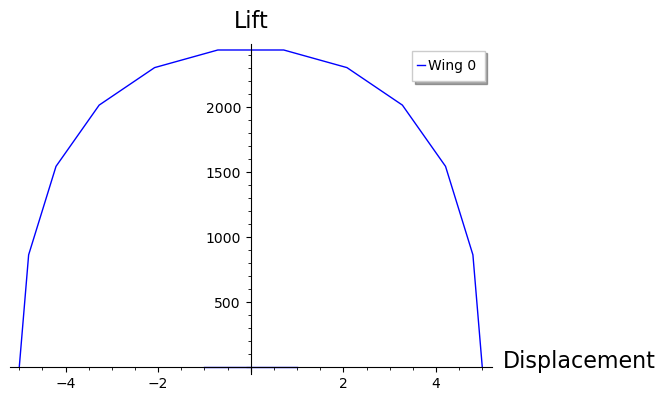

In [3]:
#wing_info format:
#[b, v_infinity, rho, "c(x)", "alphaL0(x)", "alpha(x)", N]
ref = ["b", "v_infinity", "rho", "c(theta)", "alphaL0(theta)", "alpha(theta)", "N"]
wings = [[10, 50, 1.225, "5", "0", "5 * pi/180", 10]]
color_list = ["blue", 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
totalplots = plot(0)
index = 0
for wing_info in wings:    
    vec = LiftFinder(wing_info)
    print("Total lift for wing " + str(index) + " = " + str(vec.get_total_lift()))
    totalplots = totalplots + list_plot(vec.get_zipped_lists(), legend_label=("Wing " + str(index)), color=color_list[index % 7], plotjoined = True)
    dynamic_pressure = 1/2 * wing_info[2] * wing_info[1] ^ 2
    s = wing_info[0] * average_value(wing_info[3])
    print("Lift coefficient: " + str((vec.get_total_lift()) / (dynamic_pressure * s)))
    index = index + 1
    for i in range(0, len(ref)):
        print(ref[i] + ": " + str(wing_info[i]))
    
totalplots.axes_labels(["Displacement", "Lift"])
totalplots.show()
#vec.lift_finder()
# x_ax = vec.get_x_axis_reference
# y_ax = vec.get_lift_vector
#list_plot(list(zip(x_ax, y_ax)), axes_labels = ["Displacement", "Lift"] )

b: 10
v_infinity: 50
rho: 1.22500000000000
c(theta): 5
alphaL0(theta): 0
alpha(theta): 10 * pi/180
N: 10


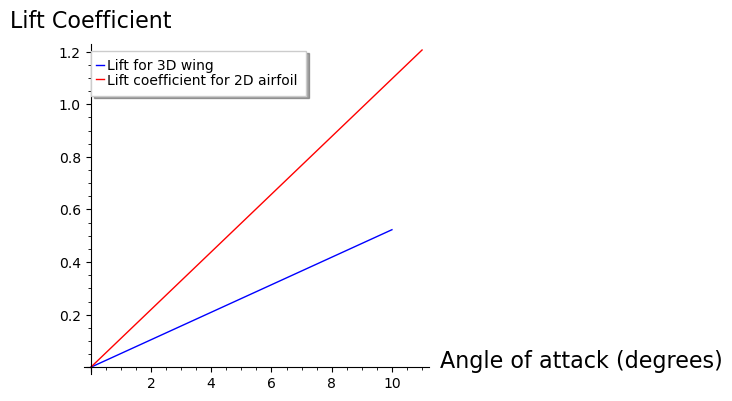

In [4]:
#Calculation of lift coefficient for varying alpha
#[b, v_infinity, rho, "c(x)", "alphaL0(x)", "alpha(x)", N]
x_axis = [i for i in range(0, 11)]
coefficients = []
for alpha in range(0, 11):
    wing_info = [10, 50, 1.225, "5", "0", str(alpha) + " * pi/180", 10]
    vec = LiftFinder(wing_info)
    dynamic_pressure = 1/2 * wing_info[2] * wing_info[1] ^ 2
    s = wing_info[0] * average_value(wing_info[3])
    coefficients.append((vec.get_total_lift()) / (dynamic_pressure * s))
for i in range(0, len(ref)):
        print(ref[i] + ": " + str(wing_info[i]))
p1 = list_plot(list(zip(x_axis, coefficients)), plotjoined=True, legend_label="Lift for 3D wing")
p2 = plot(2*pi* (x * pi / 180), (0, 11), color="red", legend_label="Lift coefficient for 2D airfoil")
p_total = p1 + p2
p_total.axes_labels(["Angle of attack (degrees)", "Lift Coefficient"])


p_total.show()

### Calculations for a Cessna 172

In [12]:
# Lift with respect to angle of attack [-10, 10 deg] for V = 75, 100, 125, 150 mph
#                                                            33.528, 44.704, 55.88, 67.056 m/s
# Wingspan = 10.9728 m
# Avg chord length = 1.472 m
# Cruising altitude of 9500 ft = 2895.6 m
#[b, v_infinity, rho, "c(x)", "alphaL0(x)", "alpha(x)", N]
#rho = 1.7833 slugs/ft3 = .909122 kg/m3
v_infinity = [33.528, 44.704, 55.88, 67.056]
alpha = [i for i in range(-10, 11)]
N = 50
c_plots = []
l_plots = []
i = 0
for v in v_infinity:
    coeffs = []
    lifts = []
    for a in alpha:
        wing_info = [10.9728, v, .909122, "1.472", "(-4) * pi / 180", str(a * pi / 180), N]
        vec = LiftFinder(wing_info)
        coeffs.append(vec.get_lift_coefficient())
        lifts.append(vec.get_total_lift())
    c_plots.append(list_plot(list(zip(alpha, coeffs)), plotjoined=True, color=color_list[i % 7]))
    l_plots.append(list_plot(list(zip(alpha, lifts)), plotjoined=True, color=color_list[i % 7]))
    i = i + 1


Plots finished for v = 33.5280000000000
Plots finished for v = 44.7040000000000
Plots finished for v = 55.8800000000000
Plots finished for v = 67.0560000000000


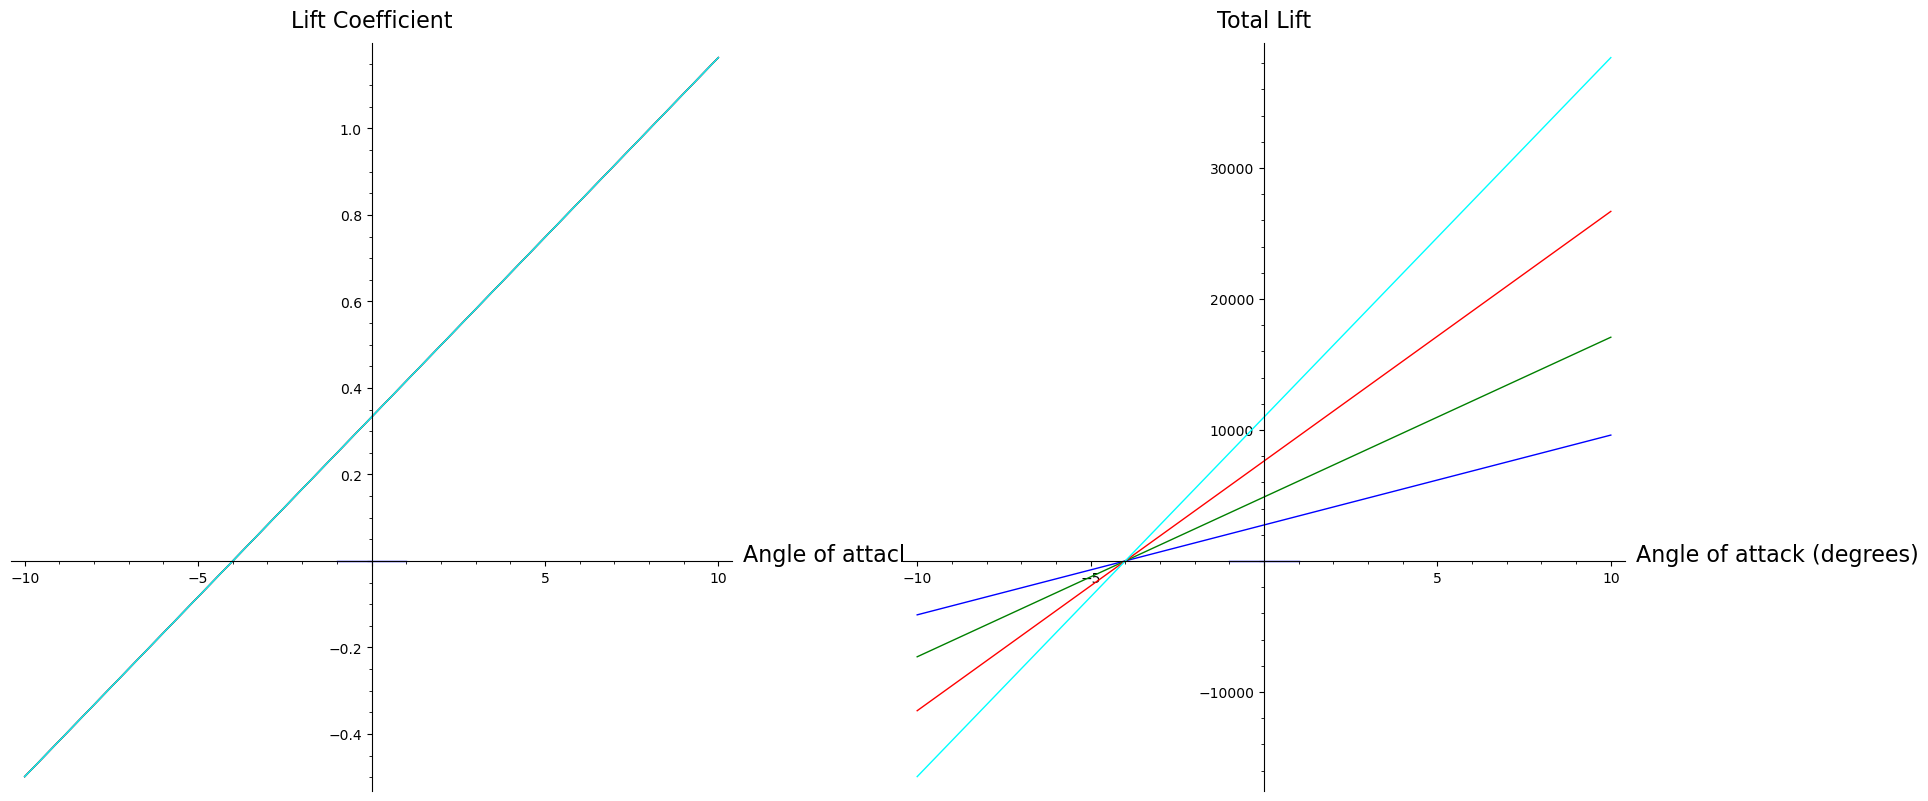

In [28]:

total_c_plots = plot(0)
total_l_plots = plot(0)

for p in c_plots:
    total_c_plots = total_c_plots + p
for p in l_plots:
    total_l_plots = total_l_plots + p
total_c_plots.axes_labels(["Angle of attack (degrees)", "Lift Coefficient"])
total_l_plots.axes_labels(["Angle of attack (degrees)", "Total Lift"])
    
ga = graphics_array(((total_c_plots),( total_l_plots)))
ga.show(figsize = [18, 8])